In this project I develop the following strategy in order to predict toxicity of multilanguage comments:

(1) 17368 comments from training set were selected and translated on six different languages using translators library;
(2) for toxic and normal comments vocabularies were created separately and then combined;
(3) the final model contain embedding layer, two layers with GRU cells and one Dense layer.

In [2]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import pandas as pd 

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

TRAIN DATA

In [3]:
# loading data
input_dir = 'data/'
def load_csv_data(input_dir, filename):
    csv_path = input_dir + filename + ".csv"
    return pd.read_csv(csv_path)

train_data_b01 = load_csv_data(input_dir, "jigsaw-toxic-comment-train-processed-seqlen128")

In [4]:
# constructing toxic labels for training dataset

train_data_b01['total_toxicity'] = 0
s = train_data_b01.shape[0]

for i in range(s):
    counter = 0
    if train_data_b01["toxic"][i] > 0:
        counter += 1
        train_data_b01['total_toxicity'][i] += train_data_b01["toxic"][i]
        
    if train_data_b01["severe_toxic"][i] > 0:
        counter += 1
        train_data_b01['total_toxicity'][i] += train_data_b01["severe_toxic"][i]
        
    if train_data_b01["obscene"][i] > 0:
        counter += 1
        train_data_b01['total_toxicity'][i] += train_data_b01["obscene"][i]
        
    if train_data_b01["threat"][i] > 0:
        counter += 1
        train_data_b01['total_toxicity'][i] += train_data_b01["threat"][i]
        
    if train_data_b01["insult"][i] > 0:
        counter += 1
        train_data_b01['total_toxicity'][i] += train_data_b01["insult"][i]
    
    if train_data_b01["identity_hate"][i] > 0:
        counter += 1
        train_data_b01['total_toxicity'][i] += train_data_b01["identity_hate"][i]
        
    if counter > 0 :
        train_data_b01['total_toxicity'][i] = train_data_b01['total_toxicity'][i]/counter

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launch

In [5]:
# trainset

data = { 'comment_text' : (train_data_b01['comment_text']),
        'toxic' : train_data_b01['total_toxicity']   
}

train_data_mod = pd.DataFrame(data, columns = ['comment_text', 'toxic'])

In [6]:
# separating normal and toxic comments

max_comment_size = 300

# remove emoji from comments
import emoji
def give_emoji_free_text(text):
    return emoji.get_emoji_regexp().sub(r'', text)

comment_normal = []
comment_toxic = []
size = train_data_mod.shape[0]
    
for i in range(size):
    comment = train_data_mod['comment_text'][i]
    comment = give_emoji_free_text(comment)
    comment = comment[0:max_comment_size].replace("<r\s*/?>", " ").replace("[^a-zA-Z']", " ")
    if train_data_mod['toxic'][i] == 0:
        comment_normal.append(comment)
    else:
        comment_toxic.append(comment)
        
normar_labels = np.zeros(len(comment_normal))
toxic_labels = np.ones(len(comment_toxic))

In [7]:
# duplicates

import collections
print([count for item, count in collections.Counter(comment_normal).items() if count > 1])
print([count for item, count in collections.Counter(comment_toxic).items() if count > 1])

[2, 2, 2, 3, 9, 80, 2, 34, 18, 2, 2, 8, 7, 3, 2, 2, 2, 4, 2, 13, 5, 41, 2, 2, 3, 2, 3, 4, 13, 3, 10, 2, 2, 16, 2, 3, 2, 2, 2, 3, 16, 2, 4, 29, 2, 2, 2, 2, 6, 2, 2, 2, 37, 2, 3, 27, 2, 6, 2, 3, 3, 4, 3, 4, 2, 12, 2, 11, 2, 2, 5, 4, 2, 3, 2, 2, 2, 2, 16, 2, 6, 2, 3, 6, 5, 2, 2, 2, 3, 6, 2, 2, 2, 2, 3, 22, 2, 7, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 7, 13, 3, 10, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 9, 2, 2, 9, 4, 2, 2, 2, 2, 2, 2, 2, 5, 3, 2, 2, 5, 2, 2, 6, 2, 8, 4, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 4, 3, 2, 2, 2, 4, 4, 6, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 5, 2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 3, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 10, 24, 20, 3, 2, 2, 2, 4, 

In [8]:
# remove duplicates

comment_normal = list(dict.fromkeys(comment_normal))
comment_toxic = list(dict.fromkeys(comment_toxic))

In [9]:
print([count for item, count in collections.Counter(comment_normal).items() if count > 1])
print([count for item, count in collections.Counter(comment_toxic).items() if count > 1])

[]
[]


In [10]:
# combining comments into text containing several comments separated by separators

def text_packet(comment_normal, comment_toxic, inds_n, inds_t, packet_size =25, separator = "######"):
    normal_comments = []
    toxic_comments = []
    
    for i in range(packet_size):
        n_ind = inds_n.pop(i)
        t_ind = inds_t.pop(i)
        normal_comments.append(comment_normal[n_ind])
        toxic_comments.append(comment_toxic[t_ind])
        
    text_normal = ''
    text_toxic = ''
    
    for comment in normal_comments:
        text_normal += comment + separator
    
    for comment in toxic_comments:
        text_toxic += comment + separator
        
    return text_normal, text_toxic  

In [11]:
# back from text to list of comments

def text_to_list(text, separator = "######"):
    text_comments = []
    text_comments = text.split(separator)
    try:
        text_comments.remove('')
    except:
        text_comments = text_comments
    return text_comments

In [12]:
# appending prepared lists of comments, labels, langs
def append_data_lists(text, toxic_list, lang_list, comment_list, toxic = 1, lang = 'tr'):
    text_list = text_to_list(text, separator = "######")
    n = len(text_list) 
    for i in range(n):
        toxic_list.append(toxic)
        lang_list.append(lang)
        comment_list.append(text_list[i])
    return toxic_list, lang_list, comment_list

In [13]:
# preparation of random indexes for data selection
def random_inds(size):
    inds = list(np.random.permutation(size))
    return inds

We are now ready to translate some train data into six different languages.

In [14]:
# translating english comments

np.random.seed(42)

len_n = len(comment_normal)
len_t = len(comment_toxic)

inds_n_tr = random_inds(len_n)
inds_t_tr = random_inds(len_t)

inds_n_pt = random_inds(len_n)
inds_t_pt = random_inds(len_t)

inds_n_ru = random_inds(len_n)
inds_t_ru = random_inds(len_t)

inds_n_fr = random_inds(len_n)
inds_t_fr = random_inds(len_t)

inds_n_it = random_inds(len_n)
inds_t_it = random_inds(len_t)

inds_n_es = random_inds(len_n)
inds_t_es = random_inds(len_t)

For translation we will use translators library and google API. Note, that the Google server block IP after some limit and we can continue process of translation only on next day. For this reason we will perform translation process in three iterations.

In [15]:
#pip install translators

In [16]:
try:
    import time
    import translators as ts
    toxic_list = []
    lang_list = []
    comment_list = []
    API = ts.google
    packet_size = 25
    sleep_time = 2
    num_iter = 24
    
    for iteration in range(num_iter):
        import translators as ts    
        print("Iteration: " + str(iteration)) 
       
        lang = 'tr'
        text_n, text_t = text_packet(comment_normal, comment_toxic, inds_n_tr, inds_t_tr, 
                                     packet_size = packet_size)
        text_t_tr = API(text_t, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_t_tr, 
                                                            toxic_list, lang_list, comment_list, 
                                                            toxic = 1, lang = lang)
        time.sleep(sleep_time)
        text_n_tr = API(text_n, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_n_tr, 
                                                            toxic_list, lang_list, comment_list, 
                                                            toxic = 0, lang = lang)
        time.sleep(sleep_time*2)
    
        lang = 'pt'
        text_n, text_t = text_packet(comment_normal, comment_toxic, inds_n_pt, inds_t_pt, 
                                     packet_size = packet_size)
        text_t_pt = API(text_t, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_t_pt, 
                                                            toxic_list, lang_list, comment_list, 
                                                            toxic = 1, lang = lang)
        time.sleep(sleep_time)
        text_n_pt = API(text_n, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_n_pt, 
                                                            toxic_list, lang_list, comment_list,
                                                            toxic = 0, lang = lang)
        time.sleep(sleep_time*2)
       
        lang = 'ru'
        text_n, text_t = text_packet(comment_normal, comment_toxic, inds_n_ru, inds_t_ru,
                                    packet_size = packet_size)
        text_t_ru = API(text_t, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_t_ru, 
                                                            toxic_list, lang_list, comment_list,                                                            toxic = 1, lang = lang)
        time.sleep(sleep_time)
        text_n_ru = API(text_n, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_n_ru, 
                                                            toxic_list, lang_list, comment_list, 
                                                            toxic = 0, lang = lang)
        time.sleep(sleep_time*2)
       
    
        lang = 'fr'
        text_n, text_t = text_packet(comment_normal, comment_toxic, inds_n_fr, inds_t_fr, 
                                     packet_size = packet_size)
        text_t_fr = API(text_t, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_t_fr, 
                                                            toxic_list, lang_list, comment_list, 
                                                            toxic = 1, lang = lang)
        time.sleep(sleep_time)
        text_n_fr = API(text_n, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_n_fr, 
                                                            toxic_list, lang_list, comment_list, 
                                                            toxic = 0, lang = lang)
        time.sleep(sleep_time*2)
    
        lang = 'it'
        text_n, text_t = text_packet(comment_normal, comment_toxic, inds_n_it, inds_t_it, 
                                     packet_size = packet_size)
        text_t_it = API(text_t, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_t_it, 
                                                            toxic_list, lang_list, comment_list, 
                                                            toxic = 1, lang = lang)
        time.sleep(sleep_time)
        text_n_it = API(text_n, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_n_it, 
                                                            toxic_list, lang_list, comment_list, 
                                                            toxic = 0, lang = lang)
        time.sleep(sleep_time*2)
    
        lang = 'es'
        text_n, text_t = text_packet(comment_normal, comment_toxic, inds_n_es, inds_t_es, 
                                     packet_size = packet_size)
        text_t_es = API(text_t, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_t_es, 
                                                            toxic_list, lang_list, 
                                                            comment_list, toxic = 1, lang = lang)
        time.sleep(sleep_time)
        text_n_es = API(text_n, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_n_es, 
                                                            toxic_list, lang_list, 
                                                            comment_list, toxic = 0, lang = lang)
        time.sleep(sleep_time*2)
        
except:
    print("Error")
       

Error


The result of translation avalible in the file mini_multilang_trainset_1.csv in the 'preprocessed_data'

In [17]:
"""
mini_multilang_trainset_1 = pd.DataFrame(columns = ['comment', 'toxic', 'lang'])
mini_multilang_trainset_1['comment'] = comment_list
mini_multilang_trainset_1['toxic'] = toxic_list
mini_multilang_trainset_1['lang'] = lang_list

mini_multilang_trainset_1.to_csv('mini_multilang_trainset_1.csv',index = False)
"""
preprocessed_dir = 'preprocessed_data/'

mini_multilang_trainset_1 = load_csv_data(preprocessed_dir, "mini_multilang_trainset_1")

Then it is neccessary to save unused indeces inds_n_tr, inds_t_tr, inds_n_pt, inds_t_pt, inds_n_ru, inds_t_ru, inds_n_fr, inds_t_fr, inds_n_it, inds_t_it, inds_n_es, inds_t_es. As it was mentioned earlier, the Google server block IP after some limit and we can continue process of translation only on next day.

DataFrames with unused undeces are avalible in the files 'unused_normal_indeces_after_step_1.csv' and 'unused_toxic_indeces_after_step_1.csv' in the 'preprocessed_data' directory.

In [18]:
"""
unused_normal_indeces_1 = pd.DataFrame(columns = ['ind_tr', 'ind_pt', 'ind_ru', 'ind_fr', 'ind_it', 'ind_es'])
unused_normal_indeces_1['ind_tr'] = inds_n_tr
unused_normal_indeces_1['ind_pt'] = inds_n_pt
unused_normal_indeces_1['ind_ru'] = inds_n_ru
unused_normal_indeces_1['ind_fr'] = inds_n_fr
unused_normal_indeces_1['ind_it'] = inds_n_it
unused_normal_indeces_1['ind_es'] = inds_n_es

unused_toxic_indeces_1 = pd.DataFrame(columns = ['ind_tr', 'ind_pt', 'ind_ru', 'ind_fr', 'ind_it', 'ind_es'])
unused_toxic_indeces_1['ind_tr'] = inds_t_tr
unused_toxic_indeces_1['ind_pt'] = inds_t_pt
unused_toxic_indeces_1['ind_ru'] = inds_t_ru
unused_toxic_indeces_1['ind_fr'] = inds_t_fr
unused_toxic_indeces_1['ind_it'] = inds_t_it
unused_toxic_indeces_1['ind_es'] = inds_t_es

unused_normal_indeces_1.to_csv('unused_normal_indeces_after_step_1',index = False)
unused_toxic_indeces_1.to_csv('unused_toxic_indeces_after_step_1.csv',index = False)
"""

unused_normal_indeces_after_step_1 = load_csv_data(preprocessed_dir, "unused_normal_indeces_after_step_1")

unused_toxic_indeces_after_step_1 = load_csv_data(preprocessed_dir, "unused_toxic_indeces_after_step_1")

In [19]:
# prepare random indeces from step 1

inds_n_tr = list(unused_normal_indeces_after_step_1['ind_tr'])
inds_t_tr = list(unused_toxic_indeces_after_step_1['ind_tr'])

inds_n_pt = list(unused_normal_indeces_after_step_1['ind_pt'])
inds_t_pt = list(unused_toxic_indeces_after_step_1['ind_pt'])

inds_n_ru = list(unused_normal_indeces_after_step_1['ind_ru'])
inds_t_ru = list(unused_toxic_indeces_after_step_1['ind_ru'])

inds_n_fr = list(unused_normal_indeces_after_step_1['ind_fr'])
inds_t_fr = list(unused_toxic_indeces_after_step_1['ind_fr'])

inds_n_it = list(unused_normal_indeces_after_step_1['ind_it'])
inds_t_it = list(unused_toxic_indeces_after_step_1['ind_it'])

inds_n_es = list(unused_normal_indeces_after_step_1['ind_es'])
inds_t_es = list(unused_toxic_indeces_after_step_1['ind_es'])

In [20]:
try:
    import time
    import translators as ts
    toxic_list = []
    lang_list = []
    comment_list = []
    API = ts.google
    packet_size = 25
    sleep_time = 2
    num_iter = 11
    
    for iteration in range(num_iter):
        import translators as ts    
        print("Iteration: " + str(iteration)) 
       
        lang = 'tr'
        text_n, text_t = text_packet(comment_normal, comment_toxic, inds_n_tr, inds_t_tr, 
                                     packet_size = packet_size)
        text_t_tr = API(text_t, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_t_tr, 
                                                            toxic_list, lang_list, comment_list, 
                                                            toxic = 1, lang = lang)
        time.sleep(sleep_time)
        text_n_tr = API(text_n, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_n_tr, 
                                                            toxic_list, lang_list, comment_list, 
                                                            toxic = 0, lang = lang)
        time.sleep(sleep_time*2)
    
        lang = 'pt'
        text_n, text_t = text_packet(comment_normal, comment_toxic, inds_n_pt, inds_t_pt, 
                                     packet_size = packet_size)
        text_t_pt = API(text_t, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_t_pt, 
                                                            toxic_list, lang_list, comment_list, 
                                                            toxic = 1, lang = lang)
        time.sleep(sleep_time)
        text_n_pt = API(text_n, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_n_pt, 
                                                            toxic_list, lang_list, comment_list,
                                                            toxic = 0, lang = lang)
        time.sleep(sleep_time*2)
       
        lang = 'ru'
        text_n, text_t = text_packet(comment_normal, comment_toxic, inds_n_ru, inds_t_ru,
                                    packet_size = packet_size)
        text_t_ru = API(text_t, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_t_ru, 
                                                            toxic_list, lang_list, comment_list,                                                            toxic = 1, lang = lang)
        time.sleep(sleep_time)
        text_n_ru = API(text_n, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_n_ru, 
                                                            toxic_list, lang_list, comment_list, 
                                                            toxic = 0, lang = lang)
        time.sleep(sleep_time*2)
       
    
        lang = 'fr'
        text_n, text_t = text_packet(comment_normal, comment_toxic, inds_n_fr, inds_t_fr, 
                                     packet_size = packet_size)
        text_t_fr = API(text_t, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_t_fr, 
                                                            toxic_list, lang_list, comment_list, 
                                                            toxic = 1, lang = lang)
        time.sleep(sleep_time)
        text_n_fr = API(text_n, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_n_fr, 
                                                            toxic_list, lang_list, comment_list, 
                                                            toxic = 0, lang = lang)
        time.sleep(sleep_time*2)
    
        lang = 'it'
        text_n, text_t = text_packet(comment_normal, comment_toxic, inds_n_it, inds_t_it, 
                                     packet_size = packet_size)
        text_t_it = API(text_t, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_t_it, 
                                                            toxic_list, lang_list, comment_list, 
                                                            toxic = 1, lang = lang)
        time.sleep(sleep_time)
        text_n_it = API(text_n, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_n_it, 
                                                            toxic_list, lang_list, comment_list, 
                                                            toxic = 0, lang = lang)
        time.sleep(sleep_time*2)
    
        lang = 'es'
        text_n, text_t = text_packet(comment_normal, comment_toxic, inds_n_es, inds_t_es, 
                                     packet_size = packet_size)
        text_t_es = API(text_t, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_t_es, 
                                                            toxic_list, lang_list, 
                                                            comment_list, toxic = 1, lang = lang)
        time.sleep(sleep_time)
        text_n_es = API(text_n, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_n_es, 
                                                            toxic_list, lang_list, 
                                                            comment_list, toxic = 0, lang = lang)
        time.sleep(sleep_time*2)
        
except:
    print("Error")
       

Error


The result of translation avalible in the file 'mini_multilang_trainset_2.csv' in the 'preprocessed_data'

In [21]:
"""
mini_multilang_trainset_2 = pd.DataFrame(columns = ['comment', 'toxic', 'lang'])
mini_multilang_trainset_2['comment'] = comment_list
mini_multilang_trainset_2['toxic'] = toxic_list
mini_multilang_trainset_2['lang'] = lang_list

mini_multilang_trainset_2.to_csv('mini_multilang_trainset_2.csv',index = False)
"""
mini_multilang_trainset_2 = load_csv_data(preprocessed_dir, "mini_multilang_trainset_2")

It is neccessary to save unused indeces inds_n_tr, inds_t_tr, inds_n_pt, inds_t_pt, inds_n_ru, inds_t_ru, inds_n_fr, inds_t_fr, inds_n_it, inds_t_it, inds_n_es, inds_t_es. 

DataFrames with unused undeces are avalible in the files 'unused_normal_indeces_after_step_2.csv' and 'unused_toxic_indeces_after_step_2.csv' in the 'preprocessed_data' directory.

In [22]:
"""
unused_normal_indeces_2 = pd.DataFrame(columns = ['ind_tr', 'ind_pt', 'ind_ru', 'ind_fr', 'ind_it', 'ind_es'])
unused_normal_indeces_2['ind_tr'] = inds_n_tr
unused_normal_indeces_2['ind_pt'] = inds_n_pt
unused_normal_indeces_2['ind_ru'] = inds_n_ru
unused_normal_indeces_2['ind_fr'] = inds_n_fr
unused_normal_indeces_2['ind_it'] = inds_n_it
unused_normal_indeces_2['ind_es'] = inds_n_es

unused_toxic_indeces_2 = pd.DataFrame(columns = ['ind_tr', 'ind_pt', 'ind_ru', 'ind_fr', 'ind_it', 'ind_es'])
unused_toxic_indeces_2['ind_tr'] = inds_t_tr
unused_toxic_indeces_2['ind_pt'] = inds_t_pt
unused_toxic_indeces_2['ind_ru'] = inds_t_ru
unused_toxic_indeces_2['ind_fr'] = inds_t_fr
unused_toxic_indeces_2['ind_it'] = inds_t_it
unused_toxic_indeces_2['ind_es'] = inds_t_es

unused_normal_indeces_2.to_csv('unused_normal_indeces_2.csv',index = False)
unused_toxic_indeces_2.to_csv('unused_toxic_indeces_2.csv',index = False)
"""

unused_normal_indeces_after_step_2 = load_csv_data(preprocessed_dir, "unused_normal_indeces_after_step_2")

unused_toxic_indeces_after_step_2 = load_csv_data(preprocessed_dir, "unused_toxic_indeces_after_step_2")

In [23]:
# preparation of random indices from step 2

inds_n_tr = list(unused_normal_indeces_after_step_2['ind_tr'])
inds_t_tr = list(unused_toxic_indeces_after_step_2['ind_tr'])

inds_n_pt = list(unused_normal_indeces_after_step_2['ind_pt'])
inds_t_pt = list(unused_toxic_indeces_after_step_2['ind_pt'])

inds_n_ru = list(unused_normal_indeces_after_step_2['ind_ru'])
inds_t_ru = list(unused_toxic_indeces_after_step_2['ind_ru'])

inds_n_fr = list(unused_normal_indeces_after_step_2['ind_fr'])
inds_t_fr = list(unused_toxic_indeces_after_step_2['ind_fr'])

inds_n_it = list(unused_normal_indeces_after_step_2['ind_it'])
inds_t_it = list(unused_toxic_indeces_after_step_2['ind_it'])

inds_n_es = list(unused_normal_indeces_after_step_2['ind_es'])
inds_t_es = list(unused_toxic_indeces_after_step_2['ind_es'])

In [24]:
try:
    import time
    import translators as ts
    toxic_list = []
    lang_list = []
    comment_list = []
    API = ts.google
    packet_size = 25
    sleep_time = 2
    num_iter = 15
    
    for iteration in range(num_iter):
        import translators as ts    
        print("Iteration: " + str(iteration)) 
       
        lang = 'tr'
        text_n, text_t = text_packet(comment_normal, comment_toxic, inds_n_tr, inds_t_tr, 
                                     packet_size = packet_size)
        text_t_tr = API(text_t, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_t_tr, 
                                                            toxic_list, lang_list, comment_list, 
                                                            toxic = 1, lang = lang)
        time.sleep(sleep_time)
        text_n_tr = API(text_n, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_n_tr, 
                                                            toxic_list, lang_list, comment_list, 
                                                            toxic = 0, lang = lang)
        time.sleep(sleep_time*2)
    
        lang = 'pt'
        text_n, text_t = text_packet(comment_normal, comment_toxic, inds_n_pt, inds_t_pt, 
                                     packet_size = packet_size)
        text_t_pt = API(text_t, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_t_pt, 
                                                            toxic_list, lang_list, comment_list, 
                                                            toxic = 1, lang = lang)
        time.sleep(sleep_time)
        text_n_pt = API(text_n, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_n_pt, 
                                                            toxic_list, lang_list, comment_list,
                                                            toxic = 0, lang = lang)
        time.sleep(sleep_time*2)
       
        lang = 'ru'
        text_n, text_t = text_packet(comment_normal, comment_toxic, inds_n_ru, inds_t_ru,
                                    packet_size = packet_size)
        text_t_ru = API(text_t, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_t_ru, 
                                                            toxic_list, lang_list, comment_list,                                                            toxic = 1, lang = lang)
        time.sleep(sleep_time)
        text_n_ru = API(text_n, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_n_ru, 
                                                            toxic_list, lang_list, comment_list, 
                                                            toxic = 0, lang = lang)
        time.sleep(sleep_time*2)
       
    
        lang = 'fr'
        text_n, text_t = text_packet(comment_normal, comment_toxic, inds_n_fr, inds_t_fr, 
                                     packet_size = packet_size)
        text_t_fr = API(text_t, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_t_fr, 
                                                            toxic_list, lang_list, comment_list, 
                                                            toxic = 1, lang = lang)
        time.sleep(sleep_time)
        text_n_fr = API(text_n, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_n_fr, 
                                                            toxic_list, lang_list, comment_list, 
                                                            toxic = 0, lang = lang)
        time.sleep(sleep_time*2)
    
        lang = 'it'
        text_n, text_t = text_packet(comment_normal, comment_toxic, inds_n_it, inds_t_it, 
                                     packet_size = packet_size)
        text_t_it = API(text_t, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_t_it, 
                                                            toxic_list, lang_list, comment_list, 
                                                            toxic = 1, lang = lang)
        time.sleep(sleep_time)
        text_n_it = API(text_n, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_n_it, 
                                                            toxic_list, lang_list, comment_list, 
                                                            toxic = 0, lang = lang)
        time.sleep(sleep_time*2)
    
        lang = 'es'
        text_n, text_t = text_packet(comment_normal, comment_toxic, inds_n_es, inds_t_es, 
                                     packet_size = packet_size)
        text_t_es = API(text_t, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_t_es, 
                                                            toxic_list, lang_list, 
                                                            comment_list, toxic = 1, lang = lang)
        time.sleep(sleep_time)
        text_n_es = API(text_n, to_language=lang)
        toxic_list, lang_list, comment_list = append_data_lists(text_n_es, 
                                                            toxic_list, lang_list, 
                                                            comment_list, toxic = 0, lang = lang)
        time.sleep(sleep_time*2)
        
except:
    print("Error")
       

Error


The result of translation avalible in the file mini_multilang_trainset_3.csv in the 'preprocessed_data'

In [25]:
"""
mini_multilang_trainset_3 = pd.DataFrame(columns = ['comment', 'toxic', 'lang'])
mini_multilang_trainset_3['comment'] = comment_list
mini_multilang_trainset_3['toxic'] = toxic_list
mini_multilang_trainset_3['lang'] = lang_list

mini_multilang_trainset_3.to_csv('mini_multilang_trainset_3.csv',index = False)
"""
mini_multilang_trainset_3 = load_csv_data(preprocessed_dir, "mini_multilang_trainset_3")

It is neccessary to save unused indeces inds_n_tr, inds_t_tr, inds_n_pt, inds_t_pt, inds_n_ru, inds_t_ru, inds_n_fr, inds_t_fr, inds_n_it, inds_t_it, inds_n_es, inds_t_es.

DataFrames with unused undeces are avalible in the files 'unused_normal_indeces_after_step_3.csv' and 'unused_toxic_indeces_after_step_3.csv' in the 'preprocessed_data' directory.

In [26]:
"""
unused_normal_indeces_3 = pd.DataFrame(columns = ['ind_tr', 'ind_pt', 'ind_ru', 'ind_fr', 'ind_it', 'ind_es'])
unused_normal_indeces_3['ind_tr'] = inds_n_tr
unused_normal_indeces_3['ind_pt'] = inds_n_pt
unused_normal_indeces_3['ind_ru'] = inds_n_ru
unused_normal_indeces_3['ind_fr'] = inds_n_fr
unused_normal_indeces_3['ind_it'] = inds_n_it
unused_normal_indeces_3['ind_es'] = inds_n_es

unused_toxic_indeces_3 = pd.DataFrame(columns = ['ind_tr', 'ind_pt', 'ind_ru', 'ind_fr', 'ind_it', 'ind_es'])
unused_toxic_indeces_3['ind_tr'] = inds_t_tr
unused_toxic_indeces_3['ind_pt'] = inds_t_pt
unused_toxic_indeces_3['ind_ru'] = inds_t_ru
unused_toxic_indeces_3['ind_fr'] = inds_t_fr
unused_toxic_indeces_3['ind_it'] = inds_t_it
unused_toxic_indeces_3['ind_es'] = inds_t_es

unused_normal_indeces_3.to_csv('unused_normal_indeces_3.csv',index = False)
unused_toxic_indeces_3.to_csv('unused_toxic_indeces_3.csv',index = False)
"""

unused_normal_indeces_after_step_3 = load_csv_data(preprocessed_dir, "unused_normal_indeces_after_step_3")

unused_toxic_indeces_after_step_3 = load_csv_data(preprocessed_dir, "unused_toxic_indeces_after_step_3")

We will select 2800 english comments 

In [27]:
# addition of english comments

len_n = len(comment_normal)
len_t = len(comment_toxic)

num_eng_comments = 2800

inds_n_en =random_inds(len_n)
inds_t_en =random_inds(len_t)

toxic_list_en = []
lang_list_en = []
comment_list_en = []

for i in range(num_eng_comments//2):
    ind = inds_n_en[i]
    comment_list_en.append(comment_normal[ind])
    lang_list_en.append('en')
    toxic_list_en.append(0)
    
for i in range(num_eng_comments//2):
    ind = inds_t_en[i]
    comment_list_en.append(comment_toxic[ind])
    lang_list_en.append('en')
    toxic_list_en.append(1)

Mini english dataset avalible as 'mini_multilang_trainset_en_s2800.csv' in the directory 'preprocessed_data'

In [28]:
"""
mini_multilang_trainset_en = pd.DataFrame(columns = ['comment', 'toxic', 'lang'])
mini_multilang_trainset_en['comment'] = comment_list_en
mini_multilang_trainset_en['toxic'] = toxic_list_en
mini_multilang_trainset_en['lang'] = lang_list_en

mini_multilang_trainset_en.to_csv('mini_multilang_trainset_en_s2800.csv',index = False)
"""
mini_multilang_trainset_en = load_csv_data(preprocessed_dir, "mini_multilang_trainset_en_s2800")

Combining all mini train sets into one

In [29]:
frames = [mini_multilang_trainset_1, mini_multilang_trainset_2, mini_multilang_trainset_3, mini_multilang_trainset_en]

mini_multilang_trainset_combo  = pd.concat(frames)
mini_multilang_trainset_combo.head()

,comment,toxic,lang
0,"Üzgünüm, ama adam bir pratt. Daha önce bana sa...",1,tr
1,Acıklı küçük kasaba fucktard. Ne kadar aptal ...,1,tr
2,t\nPHUQ OFF PEYNİR DÜĞMESİ!\n\nTUZ!\nPHUQ OFF...,1,tr
3,...\n\nİNDİRİLDİĞİNİZDE NEDEN BU YOLDA ÇALIŞI...,1,tr
4,", görünüşünüz hiç yardımcı olmuyor. Tecavüz gi...",1,tr


We can manyally check our dataset using, for example Exele or Numbers and delete some unique comments-artifacts  (I spend about 15 min checking comments). Corrected dataset avalible in the file 'mini_multilang_trainset_combo_manually_corrected.csv' in the directory 'preprocessed_data'

In [30]:
mini_multilang_trainset_combo = load_csv_data(preprocessed_dir, "mini_multilang_trainset_combo_manually_corrected")

mini_multilang_trainset_combo.drop_duplicates(keep=False,inplace=True)
mini_multilang_trainset_combo.head()

,Unnamed: 0,comment,toxic,lang
0,0,"Üzgünüm, ama adam bir pratt. Daha önce bana sa...",1,tr
1,1,Acıklı küçük kasaba fucktard. Ne kadar aptal ...,1,tr
2,2,t\nPHUQ OFF PEYNİR DÜĞMESİ!\n\nTUZ!\nPHUQ OFF...,1,tr
3,3,...\n\nİNDİRİLDİĞİNİZDE NEDEN BU YOLDA ÇALIŞI...,1,tr
4,4,", görünüşünüz hiç yardımcı olmuyor. Tecavüz gi...",1,tr


In [31]:
mini_multilang_trainset_combo['lang'].value_counts()

en    2800
ru    2491
fr    2487
it    2431
tr    2425
es    2389
pt    2345
Name: lang, dtype: int64

We will change all characters to english using translit function, clean text from artifacts and trash and split normal and toxic comments.

In [32]:
import re

def clean_text(text):
    # clear data and time
    text = re.sub('\d{2}.\d{2}.\d{2}, \d{2}:\d{2}:\d{2}', '', text)
    text = re.sub('\d{2}.\d{2} \d{2}:\d{2}', '', text)
    
    # remove whitespace before and after word
    text = re.sub('-\s\r\n\|-\s\r\n|\r\n|[«»]|[""]|[><]|"[\[]]|//"', '', text)
    text = re.sub('[«»]|[""]|[><]|"[\[]]"', '', text)
    text = re.sub('[~-¿:;_"?*!@#$^&%()]|[+=]|[[]|[]]|[/]', ' ', text)
    
    text = re.sub(r'\r\n\t|\n|\r\t|\\n|&gt', ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text)
    text = text.strip().lower()
    
    return text

In [33]:
def translit(string):
    """ This function works just fine """
    capital_letters = {

    }

    lower_case_letters = {
        u'а': u'a',
        u'б': u'b',
        u'в': u'v',
        u'г': u'g',
        u'д': u'd',
        u'е': u'e',
        u'ё': u'e',
        u'ж': u'zh',
        u'з': u'z',
        u'и': u'i',
        u'й': u'y',
        u'к': u'k',
        u'л': u'l',
        u'м': u'm',
        u'н': u'n',
        u'о': u'o',
        u'п': u'p',
        u'р': u'r',
        u'с': u's',
        u'т': u't',
        u'у': u'u',
        u'ф': u'f',
        u'х': u'h',
        u'ц': u'ts',
        u'ч': u'ch',
        u'ш': u'sh',
        u'щ': u'sch',
        u'ъ': u'',
        u'ы': u'y',
        u'ь': u'',
        u'э': u'e',
        u'ю': u'yu',
        u'я': u'ya',
        
        u'ö': u'o',
        u'ü': u'u',
        u'ş': u's',
        u'ç': u'c',
        u'ğ': u'g',
        u'â': u'a',
        u'i̇': u'i',
        
        u'ó': u'o',
        u'é': u'e',
        u'ñ': u'n',
        u'á': u'a',
        u'í': u'i',
        
        u'ã': u'a',
        u'ú': u'u',
        u'ê': u'e',
        u'à': u'a',
        u'õ': u'o',
        u'ĩ': u'i',
        u'è': u'i',
    }

    translit_string = ""

    for index, char in enumerate(string):
        if char in lower_case_letters.keys():
            char = lower_case_letters[char]
        elif char in capital_letters.keys():
            char = capital_letters[char]
            if len(string) > index+1:
                if string[index+1] not in lower_case_letters.keys():
                    char = char.upper()
            else:
                char = char.upper()
        translit_string += char

    return translit_string

In [34]:
def separate_to_lists(dataframe):
    comment_normal = []
    comment_toxic = []
    size = dataframe.shape[0]

    for i in range(size):
        comment = dataframe['comment'][i]
        lang = dataframe['lang'][i]
        comment = clean_text(comment)
        if lang != 'en':
            comment = translit(comment)            
        if dataframe['toxic'][i] == 0:
            comment_normal.append(comment)
        else:
            comment_toxic.append(comment)
        
    normar_labels = np.zeros(len(comment_normal))
    toxic_labels = np.ones(len(comment_toxic))
    
    return comment_normal, comment_toxic, normar_labels, toxic_labels

In [35]:
comment_normal, comment_toxic, labels_normal, labels_toxic = separate_to_lists(mini_multilang_trainset_combo)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Possible nested set at position 27
  # This is added back by InteractiveShellApp.init_path()


In [36]:
# preprocess text data

def preprocess(X_batch, y_batch):
    n_words = 128
    shape = tf.shape(X_batch) * tf.constant([1, 0]) + tf.constant([0, n_words])
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.lower(X_batch)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    X_batch =X_batch.to_tensor(shape=shape, default_value=b"<pad>")
    return X_batch, y_batch

In [37]:
# make tensorflow datasets

dataset_normal =  tf.data.Dataset.from_tensor_slices((tf.constant(comment_normal, dtype=tf.string), 
                                                      tf.constant(labels_normal, dtype=tf.float32)))
dataset_toxic =  tf.data.Dataset.from_tensor_slices((tf.constant(comment_toxic, dtype=tf.string), 
                                                     tf.constant(labels_toxic, dtype=tf.float32)))

In [38]:
from collections import Counter

toxic_vocabulary = Counter()
for X_batch, y_batch in dataset_toxic.batch(32).map(preprocess):
    for comment in X_batch:
        toxic_vocabulary.update(list(comment.numpy()))
        
normal_vocabulary = Counter()
for X_batch, y_batch in dataset_normal.batch(32).map(preprocess):
    for comment in X_batch:
        normal_vocabulary.update(list(comment.numpy()))

In [39]:
toxic_vocabulary.most_common()[:10]

[(b'<pad>', 880035),
 (b'de', 3930),
 (b'a', 3296),
 (b'que', 2953),
 (b'i', 2678),
 (b'e', 2370),
 (b'un', 1812),
 (b'you', 1763),
 (b'la', 1563),
 (b'ne', 1253)]

In [40]:
normal_vocabulary.most_common()[:10]

[(b'<pad>', 841741),
 (b'de', 5846),
 (b'a', 4213),
 (b'que', 3512),
 (b'i', 3051),
 (b'la', 2630),
 (b'the', 2310),
 (b'e', 2266),
 (b'o', 1643),
 (b'un', 1602)]

In [41]:
len(toxic_vocabulary), len(normal_vocabulary)

(39164, 48795)

We will combine toxic and normal vacabularies

In [42]:
new_toxic_vocabulary = toxic_vocabulary
new_normal_vocabulary = normal_vocabulary

toxic_vocabulary_list = list(new_toxic_vocabulary)
normal_vocabulary_list = list(new_normal_vocabulary)

for word in normal_vocabulary_list:
    if new_toxic_vocabulary[word] != 0:
        del new_toxic_vocabulary[word]

len(new_toxic_vocabulary), len(new_normal_vocabulary)

(22143, 48795)

In [43]:
new_toxic_vocabulary.most_common()[:10]

[(b'fuck', 550),
 (b'cunt', 148),
 (b'culo', 131),
 (b'foda', 113),
 (b'puta', 111),
 (b'suck', 92),
 (b'perra', 80),
 (b'joder', 79),
 (b'foutre', 72),
 (b'asshole', 72)]

In [44]:
normal_vocab_size = 40000
truncated_normal_vocabulary = [
    word for word, count in new_normal_vocabulary.most_common()[:normal_vocab_size]]

toxic_vocab_size = 20000
truncated_toxic_vocabulary = [
    word for word, count in new_toxic_vocabulary.most_common()[:toxic_vocab_size]]

merged_vocabulary = truncated_normal_vocabulary + truncated_toxic_vocabulary
len(merged_vocabulary)

60000

In [45]:
word_to_id = {word: index for index, word in enumerate(merged_vocabulary)}

vocab_size = normal_vocab_size + toxic_vocab_size

for word in b"fuck this shit i hate it".split():
    print(word_to_id.get(word) or vocab_size)

40000
75
19206
4
4173
50


In [46]:
for word in b"pochel v pizda urod".split():
    print(word_to_id.get(word) or vocab_size)

60000
18
40084
44598


In [48]:
num_oov_buckets = 5000

words = tf.constant(merged_vocabulary)
word_ids = tf.range(len(merged_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)

table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

table.lookup(tf.constant([b"fuck this shit i hate it".split()]))

<tf.Tensor: shape=(1, 6), dtype=int64, numpy=array([[40000,    75, 19206,     4,  4173,    50]])>

In [49]:
# preparation of efficient tensorflow train set

all_comments = comment_normal + comment_toxic
all_labels = np.concatenate((np.zeros(len(comment_normal)), np.ones(len(comment_toxic))), axis = 0)

train_dataset=  tf.data.Dataset.from_tensor_slices((tf.constant(all_comments, dtype=tf.string), 
                                                      tf.constant(all_labels, dtype=tf.float32)))

def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

batch_size = 128

train_set = train_dataset.repeat().shuffle(50000).batch(batch_size).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

We will train our model with simple GRU cells on this mini train set

In [50]:
np.random.seed(42)
tf.random.set_seed(42)

train_size = len(all_comments)
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True,
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])

optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history = model.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=8)

Train for 135 steps
Epoch 1/8
135/135 [==============================] - 79s 583ms/step - loss: 0.4267 - accuracy: 0.7893
Epoch 2/8
135/135 [==============================] - 73s 540ms/step - loss: 0.1812 - accuracy: 0.9343
Epoch 3/8
135/135 [==============================] - 72s 530ms/step - loss: 0.0765 - accuracy: 0.9758
Epoch 4/8
135/135 [==============================] - 71s 529ms/step - loss: 0.0355 - accuracy: 0.9895
Epoch 5/8
135/135 [==============================] - 72s 535ms/step - loss: 0.0165 - accuracy: 0.9953
Epoch 6/8
135/135 [==============================] - 72s 535ms/step - loss: 0.0061 - accuracy: 0.9979
Epoch 7/8
135/135 [==============================] - 76s 565ms/step - loss: 0.0038 - accuracy: 0.9988
Epoch 8/8
135/135 [==============================] - 72s 535ms/step - loss: 0.0039 - accuracy: 0.9986


In [51]:
# model.save("model.h5")

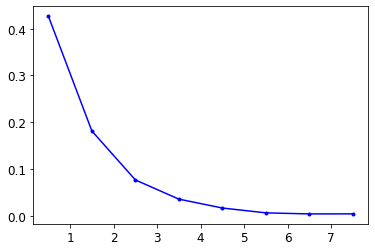

In [52]:
# Losses
plt.plot(np.arange(len(history.history["loss"])) + 0.5, history.history["loss"], "b.-", label="Training loss")

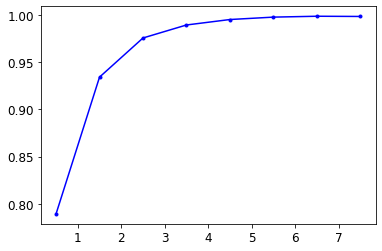

In [53]:
# Accuracy
plt.plot(np.arange(len(history.history["accuracy"])) + 0.5, history.history["accuracy"], "b.-", label="Training accuracy")

In [54]:
# make predictions for training set in order to cherck confusion matrix
pred_list = []
label_list = []

num_taken = all_labels.shape[0]//batch_size

for (X_batch, y_batch) in train_set.take(num_taken):
    batch_predictions = model.predict(X_batch)
    
    for prediction in batch_predictions:
        pred_list.append(prediction)
        
    for label in y_batch:
        label_list.append(label)
        
y_pred = np.asarray(pred_list).reshape((len(pred_list),))
y_train = np.asarray(label_list).reshape((len(label_list),))
y_train_pred = np.around(y_pred)

In [55]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train, y_train_pred)
cm

array([[9323,    5],
       [   3, 7949]])

In [56]:
# determination of accuracy, precision and recall scores for training set
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score

print("accuracy_score: " + str(accuracy_score(y_train, y_train_pred)))
print("precision_score: " + str(precision_score(y_train, y_train_pred)))
print("recall_score: " + str(recall_score(y_train, y_train_pred)))

accuracy_score: 0.999537037037037
precision_score: 0.999371385466432
recall_score: 0.9996227364185111


Now we will prepare the validation set and perform evaluation.

VALIDATION DATA

In [57]:
# preparation of validation set

valid_data_b = load_csv_data(input_dir,"validation-processed-seqlen128")

valid_data_b['lang'].value_counts()

tr    3000
it    2500
es    2500
Name: lang, dtype: int64

In [58]:
def separate_to_lists_2(dataframe):
    comments = []
    labels = []
    size = dataframe.shape[0]

    for i in range(size):
        lang = dataframe['lang'][i]
        label = dataframe['toxic'][i]
        comment = dataframe['comment_text'][i]
        comment = clean_text(comment)
        if lang != 'en':
            comment = translit(comment)                
        comments.append(comment)
        labels.append(label)
    
    return comments, labels

valid_comments, valid_labels = separate_to_lists_2(valid_data_b)

In [59]:
# tensorflow dataset

dataset_valid =  tf.data.Dataset.from_tensor_slices((tf.constant(valid_comments, dtype=tf.string), 
                                                      tf.constant(valid_labels, dtype=tf.float32)))

valid_set = dataset_valid.repeat().batch(batch_size).map(preprocess)
valid_set = valid_set.map(encode_words).prefetch(1)

In [60]:
num_taken = len(valid_labels)//batch_size

model.evaluate(valid_set.take(num_taken))

62/62 [==============================] - 13s 204ms/step - loss: 1.4876 - accuracy: 0.7547


[1.4876038278302839, 0.7546623]

In [61]:
# predictions for validation set
valid_pred_list = []
valid_label_list = []

num_taken = len(valid_labels)//batch_size

for (X_batch, y_batch) in valid_set.take(num_taken):
    batch_predictions = model.predict(X_batch)
    
    for prediction in batch_predictions:
        valid_pred_list.append(prediction)
        
    for label in y_batch:
        valid_label_list.append(label)
        
y_valid_prob = np.asarray(valid_pred_list).reshape((len(valid_pred_list),))
y_valid = np.asarray(valid_label_list).reshape((len(valid_label_list),))
y_valid_pred = np.around(y_valid_prob)

In [62]:
# check the confusion matrix
cm = confusion_matrix(y_valid, y_valid_pred)
cm

array([[5295, 1418],
       [ 529,  694]])

In [63]:
print("accuracy_score: " + str(accuracy_score(y_valid, y_valid_pred)))
print("precision_score: " + str(precision_score(y_valid, y_valid_pred)))
print("recall_score: " + str(recall_score(y_valid, y_valid_pred)))

accuracy_score: 0.7546622983870968
precision_score: 0.32859848484848486
recall_score: 0.5674570727718724


Ok. 77% of accuracy is not bed, but precision and recall scores are so low. We will continue to train model on validation set.

In [64]:
# continue training on validation data

train_size = len(valid_labels)

history = model.fit(valid_set, steps_per_epoch=train_size // batch_size, epochs=5)

Train for 62 steps
Epoch 1/5
62/62 [==============================] - 33s 531ms/step - loss: 0.3555 - accuracy: 0.8652
Epoch 2/5
62/62 [==============================] - 34s 544ms/step - loss: 0.1476 - accuracy: 0.9447
Epoch 3/5
62/62 [==============================] - 35s 569ms/step - loss: 0.0360 - accuracy: 0.9903
Epoch 4/5
62/62 [==============================] - 33s 538ms/step - loss: 0.0073 - accuracy: 0.9984
Epoch 5/5
62/62 [==============================] - 33s 534ms/step - loss: 0.0013 - accuracy: 0.9999


In [65]:
# predictions 
valid_pred_list = []
valid_label_list = []

num_taken = len(valid_labels)//batch_size

for (X_batch, y_batch) in valid_set.take(num_taken):
    batch_predictions = model.predict(X_batch)
    
    for prediction in batch_predictions:
        valid_pred_list.append(prediction)
        
    for label in y_batch:
        valid_label_list.append(label)
        
y_valid_prob = np.asarray(valid_pred_list).reshape((len(valid_pred_list),))
y_valid = np.asarray(valid_label_list).reshape((len(valid_label_list),))
y_valid_pred = np.around(y_valid_prob)

cm = confusion_matrix(y_valid, y_valid_pred)
cm

array([[6713,    0],
       [   0, 1223]])

Ok, I suppose it was considerably improve situation. We can start working with test dataset.

TEST DATA

In [66]:
test_data_b = load_csv_data(input_dir,"test-processed-seqlen128")
test_data_b.head()

,id,comment_text,input_word_ids,input_mask,all_segment_id
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,"(101, 17376, 14516, 19165, 56324, 10116, 24542...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,"Вполне возможно, но я пока не вижу необходимо...","(101, 511, 53204, 36689, 44504, 117, 11279, 57...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"Quindi tu sei uno di quelli conservativi , ...","(101, 35921, 17938, 13055, 13868, 11381, 10120...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,"(101, 59170, 16822, 99087, 10284, 83972, 51782...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,"(101, 131, 32070, 11759, 131, 11045, 23388, 10...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [67]:
test_data_b.shape

(63812, 5)

In [68]:
def separate_to_lists_test_data(dataframe):
    comments = []
    size = dataframe.shape[0]

    for i in range(size):
        comment = dataframe['comment_text'][i]
        comment = clean_text(comment)
        comment = translit(comment)
        comments.append(comment)
    
    return comments

In [69]:
test_comments = separate_to_lists_test_data(test_data_b)
pseudo_labels = np.zeros(len(test_comments))

In [70]:
len(test_comments)

63812

In [71]:
dataset_test =  tf.data.Dataset.from_tensor_slices((tf.constant(test_comments, dtype=tf.string), 
                                                      tf.constant(pseudo_labels, dtype=tf.float32)))

In [72]:
test_set = dataset_test.batch(batch_size=1).map(preprocess)
test_set = test_set.map(encode_words).prefetch(1)

In [73]:
# prediction for test set
test_pred_list = []
for data in test_set.as_numpy_iterator():
    X, y = data
    prediction = model.predict(X)
    test_pred_list.append(prediction)

len(test_pred_list)    

63812

In [74]:
y_test_prob = np.asarray(test_pred_list).reshape((len(test_pred_list),))
y_test_pred = y_test_prob

In [75]:
# percent of toxic comments in the test set
counter = 0

for prediction in y_test_pred:
    if prediction >= 0.5:
        counter+=1
        
counter, counter/len(y_test_pred), len(y_test_pred)

(12051, 0.18885162665329405, 63812)

In [76]:
# make submission file
submission = load_csv_data(input_dir, "sample_submission")
submission['toxic'] = y_test_pred
submission.to_csv('submission.csv',index = False)